# Sleep
## Sleep
#### Sleep

# Sleep Quality Assessment

### Dominique Voso
ES155 Final Project<br>
May 9, 2016

## Introduction

There are many different devices available today that claim to measure sleep quality.  From fitness trackers to iPhone apps, there are a wide variety of techniques in use to make these measurements.  However, there exists a difference between the data collected from an EEG compared to that collected from an iPhone microphone.  The question that arises is how accurate are the different methods of assessing sleep quality?  Can physiological signals and actigraphy collected from the Empatica E4 be used to create an algorithm to assess sleep quality? 

## Background

Poor sleep quality can have broad impacts, with up to 40% of US adults having trouble falling asleep or experiencing daytime sleepiness, most likely due to disturbed sleep patterns (Roebuck et al., 2013). The most accurate standard for measuring physiological signals relevant to sleep quality is polysomnography, which measure brain, eye, muscle, and heart activity. However, this is expensive, can typically only be conducted in a sleep lab, and is not practical for long term sleep studies. This has prompted a demand for more accessible options to measure sleep quality.  From this, there have arisen low-cost systems that measure sleep quality, from home sleep recording systems, to fitness trackers like FitBit and Microsoft Band, to the Sleep Cycle iPhone app that tracks quality and sets a "smart alarm" to wake a person during the lightest sleep. While some of these systems closely monitor multiple physiological signals, such as heart rate, temperature, and motion, other systems use fewer metrics, such as sound or accelerometer data, with an algorithm to measure sleep quality. In order to have the best impact for people's health, it is important that these systems give an accurate representation of sleep quality. 

To calculate sleep quality, there first needs to be an understanding the stages of sleep and the physiological signals that are indicators of these.  A night's sleep can be classified into three sections: wakefulness, non-rapid eye movement (nREM) sleep, and rapid eye movement (REM) sleep.  These classifications are made based on EEG changes.  NREM and REM sleep occur in cycles of about 90-110 min, which equates to 4-6 cycles per night (Roebuck et al., 2013).  Though classifying the sleep portion of the night into NREM and REM sleep would be helpful in more accurately measuring sleep quality, it would add an additional degree of complexity to this project.  Going forward from this point, the focus will be on classifying the night into sleep versus wake.

Previous research has shown how various physiological signals can be used to classify sleep and wakefulness.  These include, but are not limited to, movement, heart rate, temperature, and electrodermal activity.  Accelerometers have been used to assess movement and have shown that in sleep there are different types of movements, typically of a shorter duration, than those during wake (Lamprecht et al., 2014).  Analysis of variability in heart rate (Aktaruzzaman et al., 2014) and wrist electrodermal activity (Sano et al., 2014) have also been used to classify sleep.  Skin surface temperature has been shown to gradually increase during sleep, though its changes to identify periods of sleep and wake are not as definitive (Sano et al., 2014).  These previous studies give a good starting point for this project and a necessary foundation for the methods used to separate the night's sleep.  Once the night is classified into segments of sleep and wake, they can be used in an algorithm to estimate sleep quality.  Studies have shown that total sleep time, percentage of time sleeping while in bed, wakefulness and number of awakenings are the parameters with the greatest effect on sleep quality (Rospital et al., 2013).

#### The goals of this project are as follows:
1. Collect physiological data during sleep
2. Classify the sleep into sleep vs. wake 
3. Create an algorithm to assess the sleep quality 
4. Compare to commerically available systems 



## Data Collection

The experimental set up includes the following equipment:
- Microsoft Kinect
- Empatica E4
- Microsoft Band
- Sleep Cycle app

![](setup.png)

The figure above shows how the data was collected.  The Microsoft Kinect was used as a depth camera to record movements throughout the night.  The Empatica E4 was placed at the non-dominant wrist and used for accelerometer, blood volume pulse (BVP), temperature, and EDA measurements.  The Microsoft Band was also placed on the non-dominant wrist, and was used for its sleep quality assessments.  Lastly, an iPhone with the Sleep Cycle app was placed next to the bed, where it used microphone signals to identify movements and output a sleep quality assessment. 

This set up was used to record data over multiple nights.  Following a few setbacks in which devices malfunctioned, I was able to collect data for two full nights.  In the following sections, one of those nights will be analyzed.

## Microsoft Kinect 

The video from the kinect depth sensor was recorded at a frame rate of 1 frame per second throughout the entire night.  An example frame from the camera is shown below, in which you can see the head with the arm placed above it. 
<br>
![](kinect_pic.png)
<br>
Following the night of sleep, the video was manually analyzed and the type and duration of each movement was recorded.  This was used as a baseline for comparison for the accelerometer data.  The camera shows when the movement actually happened, and it is useful for verification that the accelerometer data also captures this.

First, we'll have to import some useful packages, set some constants, and import the data.

In [1]:
# Import some useful packages
import numpy as np
import scipy as sp
from scipy import signal
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt  
import sklearn
import peakutils
import csv 
%pylab inline
%matplotlib inline 

fa = 32
fb = 64
ft = 4
fe = 4
m = 60 # seconds in a min
hr = 3600 # seconds in an hour

matplotlib.rcParams.update({'font.size': 14})

Populating the interactive namespace from numpy and matplotlib


In [2]:
# import the empatica data
acc = pd.read_csv('ACC67.csv',sep=',',dtype=float64,skiprows=(2+4*fa)).values
bvp = pd.read_csv('BVP67.csv',sep=',',dtype=float64,skiprows=(2+4*fb)).values
temp = pd.read_csv('TEMP67.csv',sep=',',dtype=float64,skiprows=(2+4*ft)).values
eda = pd.read_csv('EDA67.csv',sep=',',dtype=float64,skiprows=(2+4*fe)).values

accm = pylab.demean(np.sqrt(acc[:,0]**2+acc[:,1]**2+acc[:,2]**2))
# time vectors in seconds 
timea = np.arange(np.size(accm))*float(1)/fa
timeb = np.arange(len(bvp))*(float(1)/fb)
timee = np.arange(len(eda))*(float(1)/fe)
timet = np.arange(len(temp))*(float(1)/ft)

#### Importing Kinect Data
The movements identified in the kinect video are stored in a .csv file that specifies the hour, minute, and second that the movement began and the duration of the movement.  We can import them here and create a binary array that shows when movement happened, and identify each movement as short (< 6s), medium (6-10s), or long (> 10s).  Then, we can plot this binary array and compare it with the accelerometer data from the Empatica.

In [3]:
# import the kinect data
kinect_moves = pd.read_csv('kinect_moves67.csv',sep=',',dtype=float64,skiprows=1).values

kinect_binary = zeros(len(accm))
lab = zeros(len(accm)) # label each movement as short, medium, or long

for i in np.arange(np.size(kinect_moves,axis=0)):
    tstart = fa*(hr*kinect_moves[i,0]+m*kinect_moves[i,1]+kinect_moves[i,2])
    tend = tstart+fa*kinect_moves[i,3]
    kinect_binary[tstart:tend] = 1
    if kinect_moves[i,3] < 6:
        lab[tstart:tend] = 1
    elif kinect_moves[i,3] > 10:
        lab[tstart:tend] = 3
    else:
        lab[tstart:tend] = 2


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


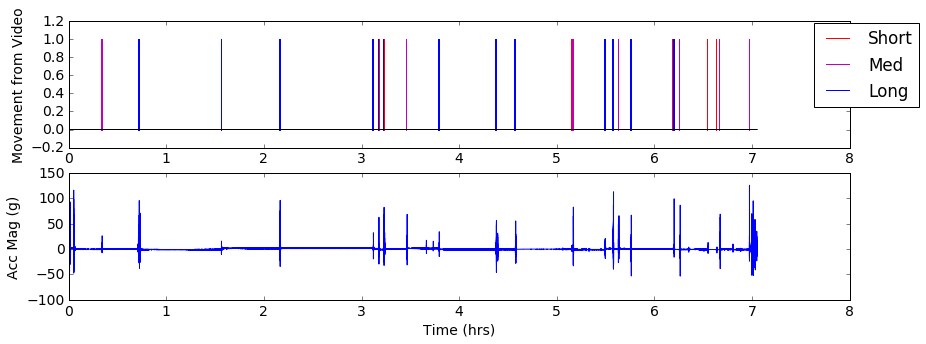

In [4]:
plt.figure(figsize=[14,5])
subplot(2,1,1)
plt.plot(timea[lab==0]/float(hr),kinect_binary[lab==0],'k')
plt.vlines(timea[lab==1]/float(hr),0,kinect_binary[lab==1],'r',label='Short')
plt.vlines(timea[lab==2]/float(hr),0,kinect_binary[lab==2],'m',label='Med')
plt.vlines(timea[lab==3]/float(hr),0,kinect_binary[lab==3],'b',label='Long')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylim(-0.2,1.2)
plt.ylabel('Movement from Video')
subplot(2,1,2)
plt.plot(timea/float(hr),accm)
plt.xlabel('Time (hrs)')
plt.ylabel('Acc Mag (g)')
plt.show()

From this graph, you can see that the movements identified from the kinect correspond to the acceleration peaks from the Empatica.  You can also see that, in the the beginning of the night, there were longer periods with no movement.  As the night progresses, movement becomes more frequent, though there are also more "short" movements at the end of the night.

##### The takeaway from this graph is that the acceleration peaks in the Empatica data do correspond to actual movement. 

## Empatica Accelerometer

In the previous section, we imported the accelerometer data and compared its magnitude to the movements identified in the kinect video.  Next, we'll take a closer look at the accelerometer data and if we can use it to identify times that are likely sleep and wake. 

First, it is useful to define a function that can take the large set of data and parse it into smaller chunks that are easier to analyze.  We will also define a binary filter that can be used to filter the data.

In [5]:
# chunks and binary_filter functions from binary_filter workbook, from ES155 staff
def chunks(array, n):
    '''
    function for dividing the detected peaks.
    array - the array to be divided
    n - number of samples per chunk
    n  = #seconds that you want to window * Fs of ACC
    '''
    sub_set = []
    for i in range(0, len(array), n):
        sub_set.append(np.sum(array[i:i+n]))
    return np.array(sub_set)

def binary_filter(y, x0, sig0, N, sigma2):
    '''
    A binary filter that takes
    y - data
    x0 - initial condition on mean
    sig0 - initial condition on varianace
    N - number of samples in data
    sigma2 - parameter sigma^2
    and outputs the filtered estimate p_t|t
    '''
    x10 = x0
    sig10 = sig0 + sigma2
    n = len(y)
    sig = np.empty(n)
    x = np.empty(n)
    p = np.empty(n)
    for t in xrange(n):
        p10 = np.exp(x10)/(1. + np.exp(x10))
        sig[t] = 1./(1/sig10 + N*p10*(1-p10))
        x[t] = x10 + sig[t]*(y[t]-N*p10)
        p[t] = np.exp(x[t])/(1. + np.exp(x[t]))
        x10 = x[t]
        sig10 = sig[t] + sigma2
    return p

In [6]:
def ZC(data,thres):
    '''
    This takes: 
    the data 
    a threshold 
    It calculates where there are zero crossings 
    '''
    ZC = zeros(len(data))
    for i in np.arange(np.size(data)-1):
        zci = (data[i]+thres)*(data[i+1]+thres)
        if zci < 0: 
            ZC[i]=1
    return ZC

There are two methods that we will use to show when acceleration changes

1. Zero crossings - these show when the acceleration changes from positive to negative 
2. Peaks - these show when acceleration reaches a maximum 

We will use both of these methods, and filter them with a binary filter, to compare their accuracy in detecting movement

#### Zero Crossings

In [7]:
# Find zero crossinga of ACC data
# Separate into epochs showing the number of zero crossings in a window

window_size = 60*fa # 60 sec window 
accZC_binary = ZC(accm,3)
accZC = chunks(accZC_binary,window_size)
timeZC = np.linspace(0,len(accm)/fa,accZC.shape[0])

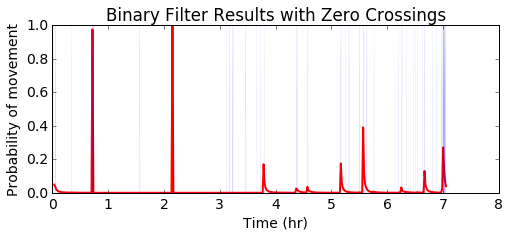

In [8]:
pW_zc = binary_filter(accZC, 0, 0, window_size, sigma2=0.01)
plt.figure(figsize=[8,3])
plt.plot(timeZC[2:]/hr,pW_zc[2:],'r',lw=2)

# Get the ylim of the plot
axes = plt.gca()
ymin, ymax = axes.get_ylim()

# plot the binary data scaled to the ylim of the plot
plt.plot(timea[2*30*fa:]/hr,accZC_binary[2*30*fa:]*ymax, alpha = 0.6, lw=0.05)
plt.title(r'Binary Filter Results with Zero Crossings')
plt.xlabel('Time (hr)')
plt.ylabel('Probability of movement')

peaks_filt_zc = peakutils.indexes(pW_zc,thres=0.006,min_dist=fa)

#### Peak finder

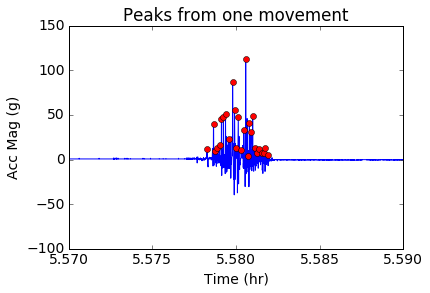

In [9]:
# find peaks of acceleration
peaksa = peakutils.indexes(accm,thres=0.02,min_dist=10)
peaktimesa = (np.asarray(peaksa))*float(1)/fa
ACC_Binary = np.zeros(accm.shape)
ACC_Binary[peaksa] = 1

plt.plot(timea/hr,accm)
plt.plot(peaktimesa/hr,accm[peaksa],'ro')
plt.xlim([5.57,5.59])
plt.xlabel('Time (hr)')
plt.ylabel('Acc Mag (g)')
plt.title('Peaks from one movement')
plt.show()

In [10]:
window_size = 60*fa # 60 s/m * sampling rate
accP = chunks(ACC_Binary, window_size)
timeP = np.linspace(0,len(accm)/fa,accP.shape[0])

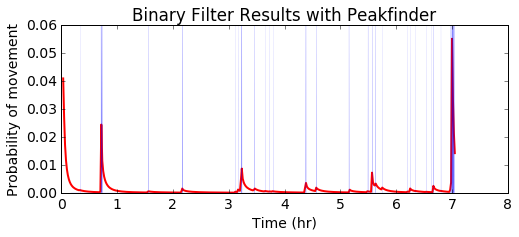

In [11]:
# use a binary filter on acceleration peaks

i = 0.01
pW_p = binary_filter(accP, 0, 0, window_size, sigma2=i)
plt.figure(figsize=[8,3])
plt.plot(timeP[2:]/hr,pW_p[2:],'r',lw=2)

# Get the ylim of the plot
axes = plt.gca()
ymin, ymax = axes.get_ylim()

plt.plot(timea[2*60*5*fa:]/hr, ACC_Binary[2*60*5*fa:]*ymax, alpha = 0.6, lw=0.1)
plt.title(r'Binary Filter Results with Peakfinder')
plt.xlabel('Time (hr)')
plt.ylabel('Probability of movement')
    

peaks_filt_p = peakutils.indexes(pW_p,thres=0.006,min_dist=fa)

<br>
<br>
Let's take a closer look at a comparison between the two filtered results
<br>

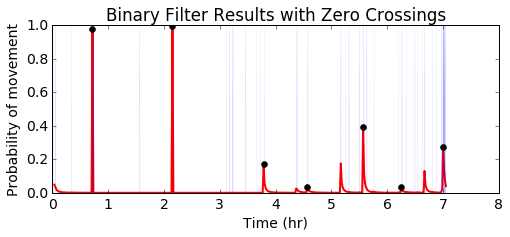

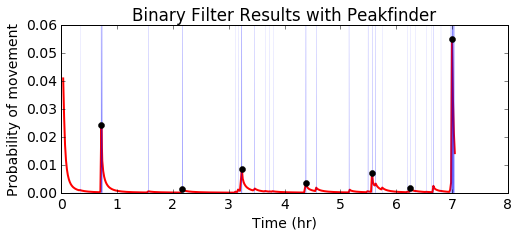

In [12]:
# Zero crossings 
plt.figure(figsize=[8,3])
plt.plot(timeZC[2:]/hr,pW_zc[2:],'r',lw=2)
# Get the ylim of the plot
axes = plt.gca()
ymin, ymax = axes.get_ylim()
# plot the binary data scaled to the ylim of the plot
plt.plot(timea[2*30*fa:]/hr,accZC_binary[2*30*fa:]*ymax, alpha = 0.6, lw=0.05)
plt.title(r'Binary Filter Results with Zero Crossings')
plt.xlabel('Time (hr)')
plt.ylabel('Probability of movement')
plt.plot(timeZC[peaks_filt_zc]/hr,pW_zc[peaks_filt_zc],'ko')
plt.show()

# Peak finder 
plt.figure(figsize=[8,3])
plt.plot(timeP[2:]/hr,pW_p[2:],'r',lw=2)
axes = plt.gca()
ymin, ymax = axes.get_ylim()
plt.plot(timea[2*60*5*fa:]/hr, ACC_Binary[2*60*5*fa:]*ymax, alpha = 0.6, lw=0.1)
plt.title(r'Binary Filter Results with Peakfinder')
plt.xlabel('Time (hr)')
plt.ylabel('Probability of movement')
plt.plot(timeP[peaks_filt_p]/hr,pW_p[peaks_filt_p],'ko')
plt.show()

In the two plots above, you can see that the binary filters on the zero crossings and on the acceleration peaks show a similar pattern for movement. Moreover, running a peakfinder on the binary filter, you can see that the movement is detected to happen at the same times. The takeaway from this graph is that both zero crossings and the peakfinder are equally valid for detecting movement.  From here onward, we will use the peakfinder, but the choice is arbitrary and both methods can work with similar success.

#### Separating the night into sleep vs. wake

Next, we can use the times that there were movement in order to separate the night's sleep into periods of sleep and wake. 

There are a few ways that this can be estimated.  One way would be to take all segments of time in which there are movement and classify those as wake, and to classify all others as sleep.  The problem with this is that there can be some movement during periods of sleep, so this might overestimate the time awake.  Instead, we can use the times that the binary filter showed movement occured.

Also, it is important to point out a few limitations of using movement to detect sleep.  Actigraphy can incorrectly determine long periods of lying still to be sleep, and it can determine periods of restless sleep to be wake.  With these limitations, it is important to keep in mind that this algorithm is a simple estimation, and more factors would be necessary in order to make it more accurate.

The method used below to separate the data simply classifies time in an eight minute window around the movement as wake, and all else as sleep. 

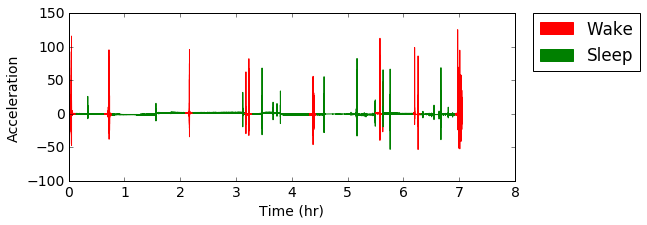

In [13]:
import matplotlib.patches as mpatches

wake_seg = 4 #4 min period before and after each peak
trans = []

trans.append(0)
trans.append(2*wake_seg*60*fa)
for i in peaks_filt_p[:-1]:
    trans.append((i-wake_seg)*60*fa)
    trans.append((i+wake_seg)*60*fa)
trans.append((peaks_filt_p[-1]-wake_seg)*60*fa)
if peaks_filt_p[-1] < len(accP)-5:
    i = peaks_filt_p[-1]
    trans.append((i+wake_seg)*60*fa)
trans.append(len(accm))

plt.figure(figsize=[8,3])
col = ['red','green']
for i in np.arange(len(trans)-1):
    t = timea[trans[i]:trans[i+1]]
    y = accm[trans[i]:trans[i+1]]
    plt.plot(t/hr,y,color=col[i%2])
plt.plot(timea[trans[-1]:]/hr,accm[trans[-1]:],color=col[(1-i)%2])

plt.xlabel('Time (hr)')
plt.ylabel('Acceleration')
red = mpatches.Patch(color='red', label='Wake')
green = mpatches.Patch(color='green', label='Sleep')
plt.legend(handles=[red,green],bbox_to_anchor=(1.3, 1.05))
plt.show()

#### Useful Parameters for Sleep Quality

- Total time in bed 
- Total time awake
- Total time asleep 
- Sleep efficiency (total time asleep / total time in bed)
- Number of times awake 

In [14]:
# total time in bed
tt_bed = len(accm)/fa # in seconds 
print "Total time in bed: %s sec" % tt_bed

# total time awake 
tt_wake = 0
for i in np.arange(0,len(trans)-1,2):
    for a in timea[trans[i]:trans[i+1]]:
        tt_wake += 1
if len(trans)%2 == 1:
    for a in timea[trans[-1]:]:
        tt_wake += 1
tt_wake = tt_wake/fa
print "Total time awake: %s sec" % tt_wake

# total time asleep
tt_sleep = tt_bed-tt_wake
print "Total time asleep: %s sec" %tt_sleep

# sleep efficiency 
efficiency = float(tt_sleep)/tt_bed
print "Sleep efficiency: %4.0f percent" % (efficiency*100)

# number of times awake 
n_wake = len(peaks_filt_p)
print "Number of times awake: %s times" %n_wake


Total time in bed: 25386 sec
Total time awake: 3786 sec
Total time asleep: 21600 sec
Sleep efficiency:   85 percent
Number of times awake: 7 times


## Empatica Heart Rate

In addition to actigraphy, variability in heart rate has been used as a metric for classifying sleep and wake.  I wanted to look further into using heart rate to help classify the night into sleep and wake.  I found that the long-term trend of heart rate changes throughout the night, generally being lower at the beginning of the night.  However, with my preliminary investigation into the data there was no difference in heart rate between the periods of sleep and wake.  In future experiments, heart rate variability could be researched further to try to find smaller differences between the classes.

In the code below, I use a peak finder on the BVP data to detect each pulse.  On this data I can use a binary filter to observe general trends of the heart rate throughout the night.  It shows that upon falling asleep, the heart rate drops, but later in the night the heart rate rises again.  This could be correlated to the increase number of movements, possibly due to restless sleep. 

I can also use the time between each peak to obtain heart rate.  This data can be averaged over a window of time for analysis.  Using this data, the mean and standard deviation of the heart rate can be found in the periods of time for sleep and wake.  What can be seen is that there isn't a clear difference between the mean or standard deviation between the two classes.

In [15]:
# Find BVP Peaks 
bvpdm = pylab.demean(bvp)
peaksb = peakutils.indexes(bvpdm[:,0],thres=0.2/max(bvpdm),min_dist=fb/2)
peaktimesb = (np.asarray(peaksb)+1)*float(1)/fb

# convert to binary
BVP_Binary = np.zeros(bvpdm.shape)
BVP_Binary[peaksb] = 1

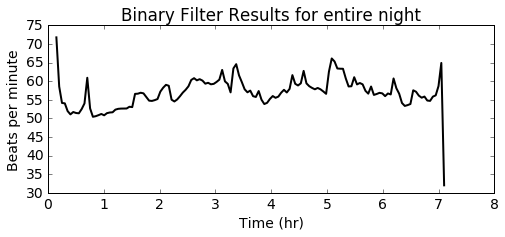

In [16]:
# binary filter of entire night 
window_size = 3*60*fb # 15 s/m * sampling rate
bvpP = chunks(BVP_Binary, window_size)
time_bP = np.linspace(0,len(bvpP)*window_size/fb,bvpP.shape[0])
hrtP = bvpP/30*60
i=0.01
pW = binary_filter(bvpP, 0, 0, window_size, sigma2=i)
plt.figure(figsize=[8,3])
plt.plot(time_bP[3:]/float(hr),pW[3:]*fb*60,'k',lw=2)
plt.title(r'Binary Filter Results for entire night')
plt.xlabel('Time (hr)')
plt.ylabel('Beats per minute')
plt.show()

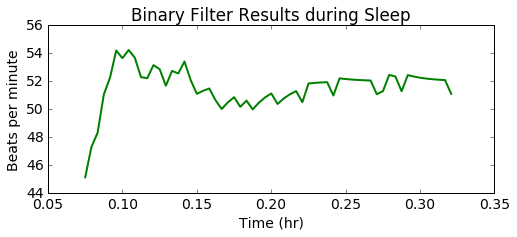

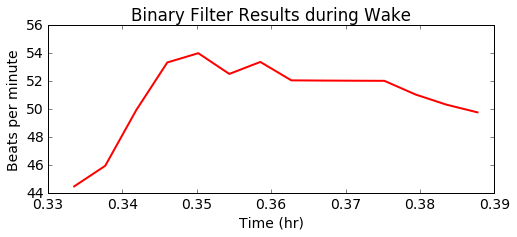

In [17]:
# plot the filtered segment for one representative segment of sleep and wake
window_size = 15*fb # 15 s/m * sampling rate
bvpP = chunks(BVP_Binary, window_size)
time_bP = np.linspace(0,len(bvpP)*15,bvpP.shape[0])
hrtP = bvpP/30*60

col = ['red','green']
lab = ['Sleep','Wake']
for ind in range(1,3):
    i = 0.0062
    start = trans[ind]/window_size
    stop = trans[ind+1]/window_size
    pWb = binary_filter(bvpP[start:stop], 13, 0, window_size, sigma2=i)
    plt.figure(figsize=[8,3])
    plt.plot(time_bP[start+2:stop]/hr,pWb[2:]*fb*60,color=col[ind%2],lw=2)
    plt.title(r'Binary Filter Results during %s' %lab[ind-1])
    plt.xlabel('Time (hr)')
    plt.ylabel('Beats per minute')
    plt.show()

The graphs above are two representative segments, of sleep and wake respectively.  There was not a clear difference between heart rate in the two segments

#### Calculating mean and variability of heart rate in the segments

In [18]:
# calculate heart rate using time between two peaks
win = 1
dist = []
for i in np.arange(len(peaksb)-win):
    dist.append(peaksb[i+win]-peaksb[i])
hrt = float(1)*win*m*fb/np.asarray(dist)
meanhr = np.mean(hrt)
print "The mean heart rate throughout the night was %4.4s beats per min" % meanhr

The mean heart rate throughout the night was 58.3 beats per min


//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


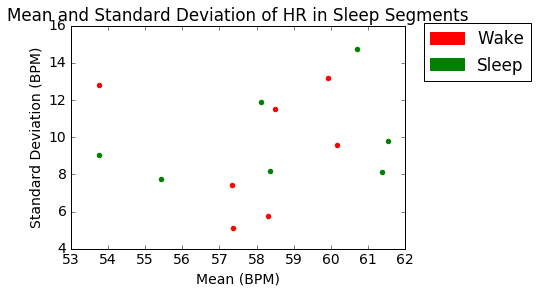

In [19]:
lab = [0,1]
mean = []
std = []
clas = zeros(len(trans)-1)
for ind in range(0,len(trans)-1):
    start = trans[ind]*2/(fb)
    stop = trans[ind+1]*2/(fb)
    mean.append(np.mean(hrt[start:stop]))
    std.append(np.std(hrt[start:stop]))
    if ind%2 == 1:
        clas[ind]=1

col = ['red','green']
for i in range(0,len(mean)):
    for j in range(0,2):
        if clas[i]==j:
            plt.scatter(mean[i],std[i],color=col[j])
plt.title('Mean and Standard Deviation of HR in Sleep Segments')
plt.xlabel('Mean (BPM)')
plt.ylabel('Standard Deviation (BPM)')
red = mpatches.Patch(color='red', label='Wake')
green = mpatches.Patch(color='green', label='Sleep')
plt.legend(handles=[red,green],bbox_to_anchor=(1.4, 1.05))
plt.show()


The scatter plot above shows the mean and standard deviation of the heart rate in the sleep and wake segments did not seem to differ.  It is possible that there is an underlying difference that is not seen when averaging heart rate over long periods of time.  In the future, this could be explored further.

## Empatica Temperature and EDA

Temperature and electrodermal activity have some associations with sleep.  We will take a brief look at the data collected.  You can see that skin temperature increases throughout the night, which is consistent with what has been previously reported (Sano et al., 2014).  EDA shows some interesting patterns as well, though the large peaks are most likely motion artifact.  Though EDA peaks can be used as an indicator of sleep stages, I did not analyze EDA in this project due to time limitations.

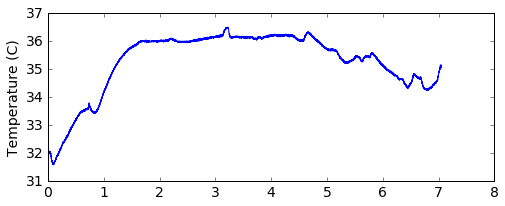

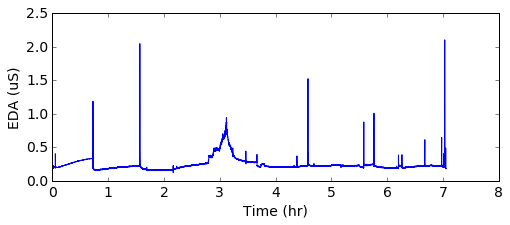

In [20]:
# Plot temperature and EDA
plt.figure(figsize=[8,3])
plt.plot(timet/float(hr),temp)
plt.ylabel('Temperature (C)')
plt.figure(figsize=[8,3])
plt.plot(timee/float(hr),eda)
plt.xlabel('Time (hr)')
plt.ylabel('EDA (uS)')
plt.show()

## Sleep Quality 

In the accelerometer section above, we calculated a few parameters that are important for sleep quality, such as total time in bed and sleep efficiency.  These parameters can be used to create an algorithm for estimate sleep quality.  The algorithm compares the estimated parameters to what would be considered ideal: 8 hours of sleep, 100% efficiency, no awakenings.  This algorithm is limited--it weights all of the parameters equally, even though realistically some may be more important than others for sleep quality.  This algorithm is very preliminary, and it could definitely be refined to be more complex and accurate given more time and data.  

In [21]:
efficiency_ideal = 1
n_wake_ideal = 2 #wake at beginning and end of night
tt_bed_ideal = 8*hr

quality = (float(tt_bed)/tt_bed_ideal+float(efficiency)/efficiency_ideal+float(n_wake_ideal)/n_wake)/3
print "The sleep quality is %4.1f percent" % (quality*100)

The sleep quality is 67.3 percent


Another question that arises is what does a sleep quality of this percentage mean?  Without a standard to compare against, it is difficult to say whether this percentage indicates poor or good sleep.  This number would be more meaningful if it were comparing multiple nights of data.

## Microsoft Band

In addition to giving an assessment of sleep quality as poor, good, or optimal, the Microsoft Band also outputs some data including total time asleep, total time awake, sleep efficiency, and number of awakenings.  Interestingly, the Band estimated the total time awake and the number of awakenings to be fewer than I have estimated above.  This could be due to errors in my calculations that overestimated how much movement was due to being awake, or this could be an underestimate by the Band.  Without an EEG to verify, there is no way to know for sure which method is more accurate.

In [22]:
# time in bed, awake, asleep, awakenings, efficiency, 
mband = [25478, 1785, 23692, 3, 96]

print "Total time in bed: \t%s sec\t band: %s sec" % (tt_bed, mband[0])

print "Total time awake: \t%s sec\t band: %s sec" % (tt_wake, mband[1])

print "Total time asleep: \t%s sec\t band: %s sec" % (tt_sleep, mband[2])

print "Sleep efficiency: \t%4.1f percent\t band: %4.1f percent" % (efficiency*100, mband[4])

print "Number of times awake: \t%s times\t\t band: %s times" % (n_wake, mband[3])

print "Sleep quality: \t\t%4.1f percent \t band: %s" % (quality*100,'Good')

Total time in bed: 	25386 sec	 band: 25478 sec
Total time awake: 	3786 sec	 band: 1785 sec
Total time asleep: 	21600 sec	 band: 23692 sec
Sleep efficiency: 	85.1 percent	 band: 96.0 percent
Number of times awake: 	7 times		 band: 3 times
Sleep quality: 		67.3 percent 	 band: Good


## Sleep Cycle

The sleep cycle app for the iPhone uses the microphone to detect sounds of movement throughout the night.  The app does not output any data, but it does give a percentage for sleep quality.  For the night analyzed here, the app outputted a quality of 72%, which is slightly higher than the 67% that I calculated.  There could be potential complications with using the microphone to detect movement; for example, I live outside of the shuttle stop, where a bus loudly drives by multiple times a night.  This could be detected by sleep cycle as movement.  Additionally, across multiple nights, there was clearly a difference between the Microsoft Band and the sleep cycle's assessment of sleep quality.  In the future, with more nights of Empatica data collected, these three systems could be compared to see if there are correlations. 

## Conclusions and Next Steps

#### Limitations 
There were a number of limitations in this project.  First, the number of nights in which I was able to collect data from all of the devices was small (2 nights).  In addition to sample size, there were also limitations in classifying the night into sleep vs. wake, since there was no way to assess if the classifications were accurate.  Having data from a EEG to definitively identify different periods would have been incredibly useful.  In comparing the Empatica to the Microsoft Band and Sleep Cycle, there were limitations in not being able to access the raw data that the Microsoft Band and Sleep Cycle use. Lastly, many of my calculations involved numerous simplifications of otherwise complex systems.

To overcome these limitations in the future, the data collection can be done over a longer span of nights, and even with multiple subjects.  Use of polysomnography would be ideal as well, though there are other devices like an eye movement detector to detect periods of REM sleep.  Analyzing multiple nights would be helpful in comparing sleep quality to create a better algorithm and further understand the results.  Future work could address some of the simplifications that were made and make more accurate assumptions. 

#### Next steps
- Classify sleep segments into REM and nREM 
- Explore using EDA to classify sleep 
- Further explore using difference measures of heart rate variability 
- Classify sleep quality for more nights in order to get a more accurate comparison 
- Compare sleep cycle, Microsoft Band, and my Empatica algorithm for sleep quality for multiple nights
- Develop a program to automate movement detection from kinect camera 

In conclusion, sleep is complex.  There is a demand for more accessible systems to assess sleep quality, and devices that measure physiological signals hold a great deal of potential.  I have explored a few of the physiological signals measured by the Empatica E4, focusing on the accelerometer and movement, to classify a night into periods of sleep and wake.  Using this, I was able to create an algorithm to assess sleep quality.  In the future, more can still be done in order to refine this algorithm.  Incorporating heart rate variability or EDA can improve the classification into sleep and wake, and analyzing a larger number of nights of sleep can help refine the algorithm and make better assessments of sleep quality.  Without a large number of nights I was limited in my ability to comprehensively compare the different devices, but preliminary findings showed variations between them.  This project presents a simple method and algorithm for determining sleep quality, which can be used in comparison to other available devices for assessing sleep quality.

## Acknowledgements

Thank you to Prof. Demba Ba, Yasha, and Diana for their support, guidance, and materials throughout this project.

## References

Aktaruzzaman, M., Migliorini, M., Tenhunen, M., Himanen, S. L., Bianchi, A. M., & Sassi, R. (2015). The addition of entropy-based regularity parameters improves sleep stage classification based on heart rate variability. Medical & biological engineering & computing, 53(5), 415-425.

Kirjavainen, T., Cooper, D., Polo, O., & SULLIVAN, C. (1996). Respiratory and body movements as indicators of sleep stage and wakefulness in infants and young children. Journal of sleep research, 5(3), 186-194.

Lamprecht, M. L., Bradley, A. P., Tran, T., Boynton, A., & Terrill, P. I. (2014). Multisite accelerometry for sleep and wake classification in children. Physiological measurement, 36(1), 133.

Lawson, S., Jamison-Powell, S., Garbett, A., Linehan, C., Kucharczyk, E., Verbaan, S., ... & Morgan, K. (2013, April). Validating a mobile phone application for the everyday, unobtrusive, objective measurement of sleep. In Proceedings of the SIGCHI Conference on Human Factors in Computing Systems (pp. 2497-2506). ACM.

Marino, M., Li, Y., Rueschman, M. N., Winkelman, J. W., Ellenbogen, J. M., Solet, J. M., ... & Buxton, O. M. (2013). Measuring sleep: accuracy, sensitivity, and specificity of wrist actigraphy compared to polysomnography. Sleep, 36(11), 1747.

Roebuck, A., Monasterio, V., Gederi, E., Osipov, M., Behar, J., Malhotra, A., ... & Clifford, G. D. (2013). A review of signals used in sleep. Physiological measurement, 35(1), R1.

Rosipal, R., Lewandowski, A., & Dorffner, G. (2013). In search of objective components for sleep quality indexing in normal sleep. Biological psychology, 94(1), 210-220.

Sano, A., Picard, R. W., & Stickgold, R. (2014). Quantitative analysis of wrist electrodermal activity during sleep. International Journal of Psychophysiology, 94(3), 382-389.
